**Data Mining - Home Assignment 1**

Group 5:
- **Alberto Fallocco**
- **Emanuele Tartaglione**
- **Marcel Buczkowski**

Time spent - 5 hours each


In [22]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.metrics.cluster import silhouette_score, silhouette_samples, calinski_harabasz_score, homogeneity_score, completeness_score, v_measure_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_train_normal = pd.read_csv('train.csv')
data_unique_normal = pd.read_csv('unique_m.csv')
data_unique_normal = data_unique_normal.drop("material", axis = 1)

# SPLIT INTO X and y both datasets
data_train = data_train_normal.drop("critical_temp", axis = 1).values
data_train_y = data_train_normal["critical_temp"]
data_unique = data_unique_normal.drop("critical_temp", axis = 1).values
data_unique_y = data_unique_normal["critical_temp"]

We decided to proceed with our work on a separate fashion with regards to the train and the unique datasets. At first, we compared the agglomerative with k-means approaches, as these are distance-based methods, then we explored the use of DBSCAN and OPTICS. Lastly, we evaluated the performances using intrinsic and extrinsic methods, in order to choose the best clustering algorithm.  <br>

As a first step, we tested the best linkage method among different agglomerative clustering methods for a fixed number of clusters (4). 

In [2]:
methods = ['single', 'average', 'complete', 'ward']
for method in methods:
    hac = AgglomerativeClustering(linkage=method, n_clusters=3).fit(data_train)
    sil_h = silhouette_score(data_train, hac.labels_)   
    print(f"Method {method} silhouette score - {round(sil_h,4)}")

Method single silhouette score - 0.5374
Method average silhouette score - 0.575
Method complete silhouette score - 0.3042
Method ward silhouette score - 0.5019


As shown above, the average linkage method performed best among linkage-based agglomerative approaches. 

In [3]:
def avgDist(X, labels):
    D=pdist(X, metric='euclidean')
    dmatrix=squareform(D, checks=True)
    N=len(labels)
    L=list(set(labels))
    L.sort()
    result=0
    for i in L:
        Nc=sum(labels==i)
        S=0
        if Nc>1: S=np.sum(dmatrix[labels==i,:][:,labels==i])/(Nc*(Nc-1))
        result+=S*Nc/N
    return result

results_1 = {'sil_k': [], 'sil_h': [], 'calhar_k': [], 'calhar_h': [], 'dist_k': [], 'dist_h': []}
for K in range(2,6):
    kms = KMeans(n_clusters=K, random_state=0).fit(data_train)
    hac = AgglomerativeClustering(linkage="average", n_clusters=K).fit(data_train)
    sil_k = silhouette_score(data_train, kms.labels_);results_1['sil_k'].append(sil_k)
    sil_h = silhouette_score(data_train, hac.labels_);results_1['sil_h'].append(sil_h)
    calhar_k = calinski_harabasz_score(data_train, kms.labels_);results_1['calhar_k'].append(calhar_k)
    calhar_h = calinski_harabasz_score(data_train, hac.labels_);results_1['calhar_h'].append(calhar_h)
    dist_k = avgDist(data_train, kms.labels_);results_1['dist_k'].append(dist_k)
    dist_h = avgDist(data_train, hac.labels_);results_1['dist_h'].append(dist_h)

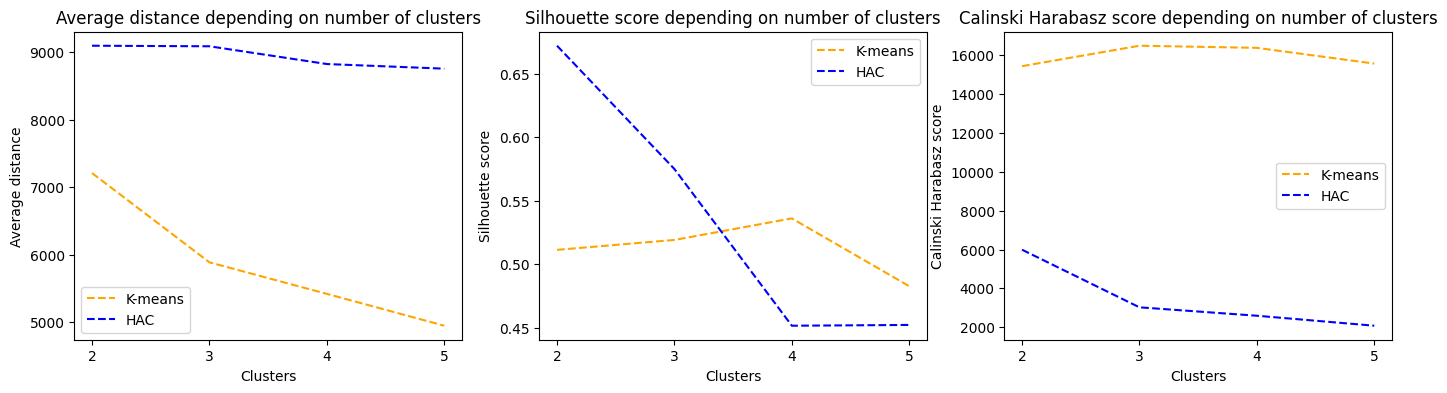

In [4]:
clusts = [2,3,4,5]
plt.figure(figsize=(17,4))
plt.subplot(1, 3, 1);plt.plot(clusts, results_1['dist_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['dist_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Average distance');plt.title('Average distance depending on number of clusters');plt.legend()
plt.subplot(1, 3, 2);plt.plot(clusts, results_1['sil_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['sil_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Silhouette score');plt.title('Silhouette score depending on number of clusters');plt.legend()
plt.subplot(1, 3, 3);plt.plot(clusts, results_1['calhar_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_1['calhar_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Calinski Harabasz score');plt.title('Calinski Harabasz score depending on number of clusters');plt.legend()
plt.show()

Given the silhouette scores, it seems best to use the K-means method for 4 clusters. We did not choose HAC with two clusters because the silhouette scores did not differ a lot and HAC is compuationally more expensive than Kmeans algorithm.<br>
Calinski Harabasz in general has higher values in Kmeans than HAC indicated by nature of these two algorithms thus we cannot fully rely only on this measure to compare two approaches but it usually useful to choose the number of clusters.

Then we decided to visualize the distribution of each cluster for Kmeans approach.

In [3]:
kms = KMeans(n_clusters=4, random_state=0).fit(data_train)
print('Cluster distribution in Kmeans with 4 clusters')
for i, label in enumerate(set(kms.labels_)):
    print(f'Cluster {i+1}: {np.count_nonzero(kms.labels_==label)}')

Cluster distribution in Kmeans with 4 clusters
Cluster 1: 12482
Cluster 2: 6477
Cluster 3: 691
Cluster 4: 1613


Then we used DBSCAN and OPTICS. <br>
First we computed the average distance in order to estimate the epsilon parameter.

In [10]:
D=pdist(data_train, metric='euclidean')
dists=squareform(D, checks=True)
mean_D=sum(D)/len(D)
print("\nAverage distance: ", mean_D)


Average distance:  9897.244974500325


Next step was to run the DBSCAN algorithm.

In [21]:
df = pd.DataFrame(columns=['Nmin', 'Eps', 'Nclust', 'Clust', 'ShScore'])
for eps in [mean_D/2, mean_D/2.5, mean_D/3]:
    for Nmin in [20, 50, 70]:
        db = DBSCAN(eps=eps, min_samples = Nmin).fit(data_train)
        nclusts=len(set(db.labels_))
        df.loc[len(df.index)] = [Nmin, round(eps), nclusts, np.bincount(1+ db.labels_), silhouette_score(data_train, db.labels_+1)]
print(df.groupby(['Eps', 'Nmin']).head())

   Nmin   Eps  Nclust                         Clust   ShScore
0    20  4949       3              [26, 21105, 132]  0.610825
1    50  4949       2                  [268, 20995]  0.683767
2    70  4949       2                  [329, 20934]  0.677675
3    20  3959       5      [117, 21034, 39, 44, 29]  0.588943
4    50  3959       2                  [551, 20712]  0.652431
5    70  3959       2                  [679, 20584]  0.642602
6    20  3299       6  [340, 20811, 18, 25, 33, 36]  0.364098
7    50  3299       2                  [847, 20416]  0.621054
8    70  3299       4        [995, 19165, 1022, 81]  0.449888


The silhouette scores are satisfactionary but the results are meaningless as the majority of the elements falls in one cluster only: this means either all the elements are part of one huge cluster or DBSCAN does not work well.

We then run the OPTICS algorithm.

In [12]:
samples = [80, 120, 150]
for S in samples:
    clust = OPTICS(min_samples=S)
    clust.fit(data_train)
    labels, counts=np.unique(clust.labels_[clust.ordering_], return_counts=True)
    for i, L in enumerate(labels):
        if L==-1: print("UNDEFINED points:", counts[i])
        break
    print(f'Number of clusters: {len(labels)}')
    print(f'Silhouette score: {silhouette_score(data_train, clust.labels_)}')

UNDEFINED points: 15772
Number of clusters: 31
Silhouette score: -0.33326723116965495
UNDEFINED points: 16664
Number of clusters: 21
Silhouette score: -0.35263650142495956
UNDEFINED points: 17865
Number of clusters: 12
Silhouette score: -0.4223615835348126


Most of the points fall in as noise, silhouette scores are negative which indicates that the algorithm did not perform well. We restrained from trying to refine DBSCAN with OPTICS by choosing the best epsilon value because clearly density-based clustering methods are not handling this dataset so well.<br>
Lastly we visualised each method with its best parameters, to compare and choose the best method in general.

In [16]:
import matplotlib.cm as cm
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)
    fig = plt.figure(figsize=(5,3))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header);ax1.set_xlabel("Silhouette coefficient");ax1.set_ylabel("Clusters");ax1.axvline(x=sil_avg, c="r", linestyle="--");ax1.set_yticks([]) 
    plt.show()


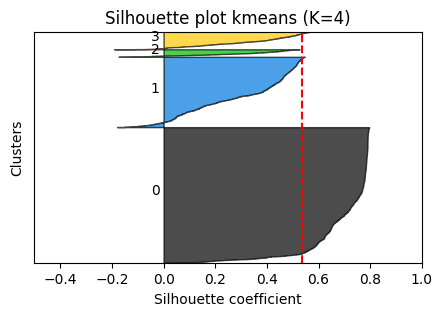

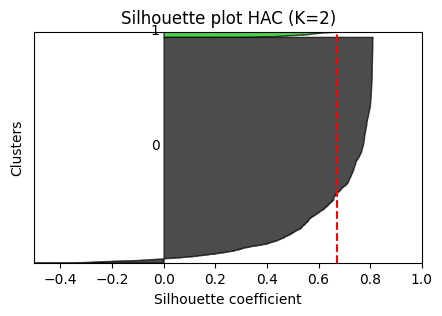

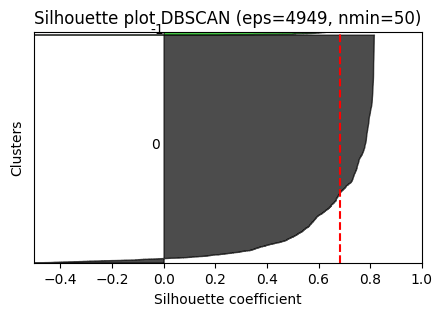

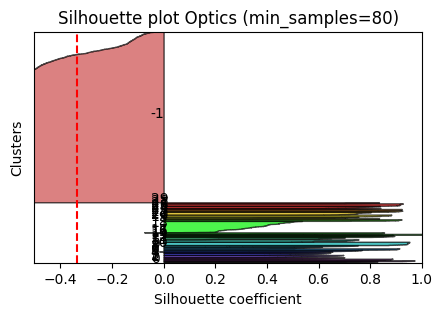

In [17]:
kms_t = KMeans(n_clusters=4, random_state=0).fit(data_train);drawSillouette(data_train, kms_t.labels_, "kmeans (K=4)")
hac_t = AgglomerativeClustering(linkage="average", n_clusters=2).fit(data_train);drawSillouette(data_train, hac_t.labels_, "HAC (K=2)")
db_t = DBSCAN(eps=mean_D/2, min_samples=50).fit(data_train);drawSillouette(data_train, db_t.labels_, "DBSCAN (eps=4949, nmin=50)")
clust_T = OPTICS(min_samples=80).fit(data_train);drawSillouette(data_train, clust_T.labels_, "Optics (min_samples=80)")

None of the plots above report good results. In optics most of the data is classified as noise and in DBSCAN as said before almost whole data is qualified into just one cluster.
However Kmeans seems to work quite well thus we can state that the best algorithm is Kmeans.

We then proceeded by carrying out the analysis on the unique dataset.

In [25]:
methods = ['single', 'average', 'complete', 'ward']
for method in methods:
    hac = AgglomerativeClustering(linkage=method, n_clusters=4).fit(data_unique)
    sil_h = silhouette_score(data_unique, hac.labels_)   
    print(f"Method {method} silhouette score - {round(sil_h,4)}")

Method single silhouette score - 0.909
Method average silhouette score - 0.9105
Method complete silhouette score - 0.8635
Method ward silhouette score - 0.8752


Average linkage performs the best among agglomerative methods.

In [26]:
results_2 = {'sil_k': [], 'sil_h': [], 'calhar_k': [], 'calhar_h': [], 'dist_k': [], 'dist_h': []}
for K in range(2,6):
    kms = KMeans(n_clusters=K, random_state=0).fit(data_unique)
    hac = AgglomerativeClustering(linkage="average", n_clusters=K).fit(data_unique)
    sil_k = silhouette_score(data_unique, kms.labels_);results_2['sil_k'].append(sil_k)
    sil_h = silhouette_score(data_unique, hac.labels_);results_2['sil_h'].append(sil_h)
    calhar_k = calinski_harabasz_score(data_unique, kms.labels_);results_2['calhar_k'].append(calhar_k)
    calhar_h = calinski_harabasz_score(data_unique, hac.labels_);results_2['calhar_h'].append(calhar_h)
    dist_k = avgDist(data_unique, kms.labels_);results_2['dist_k'].append(dist_k)
    dist_h = avgDist(data_unique, hac.labels_);results_2['dist_h'].append(dist_h)

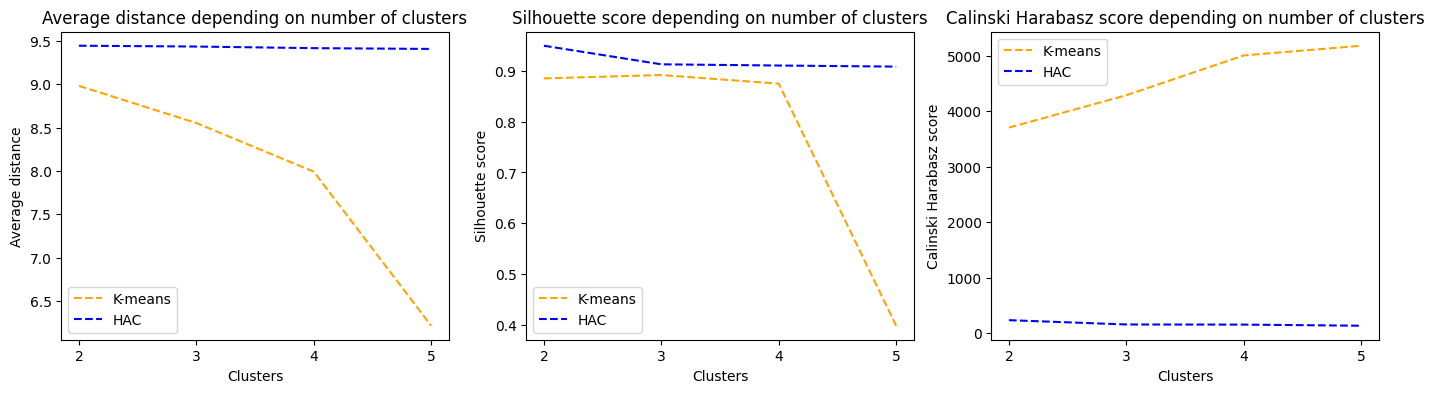

In [35]:
clusts = [2,3,4,5]
plt.figure(figsize=(17,4))
plt.subplot(1, 3, 1);plt.plot(clusts, results_2['dist_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_2['dist_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Average distance');plt.title('Average distance depending on number of clusters');plt.legend()
plt.subplot(1, 3, 2);plt.plot(clusts, results_2['sil_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_2['sil_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Silhouette score');plt.title('Silhouette score depending on number of clusters');plt.legend()
plt.subplot(1, 3, 3);plt.plot(clusts, results_2['calhar_k'], '--', color = 'orange',  label ='K-means');plt.plot(clusts, results_2['calhar_h'], '--', color = 'blue',  label ='HAC');plt.xticks(clusts);plt.xlabel('Clusters');plt.ylabel('Calinski Harabasz score');plt.title('Calinski Harabasz score depending on number of clusters');plt.legend()
plt.show()

This time the silhouette scores turned out to be satisfying for HAC and K-means, both methods scoring over 90. The Calinkski Harabasz gets better for Kmeans as the number of clusters increases. Since there is no significant difference between the two methods when it comes to a 4-cluster partition (which is also a good value for the average distance intra cluster for Kmeans), we decided to stick to Kmeans for further analysis, also due to the facts that Kmeans is computationally less espensive than HAC.

In [6]:
kms = KMeans(n_clusters=4, random_state=0).fit(data_unique)
print('Cluster distribution in Kmeans with 4 clusters')
for i, label in enumerate(set(kms.labels_)):
    print(f'Cluster {i+1}: {np.count_nonzero(kms.labels_==label)}')

Cluster distribution in Kmeans with 4 clusters
Cluster 1: 20978
Cluster 2: 91
Cluster 3: 109
Cluster 4: 85


Looking at the distribution above we can conclude that majority of the data falls into one cluster.

In [36]:
D=pdist(data_unique, metric='euclidean')
dists=squareform(D, checks=True)
mean_D=sum(D)/len(D)
print("\nAverage distance: ", mean_D)


Average distance:  9.46168576214303


In [39]:
df_2 = pd.DataFrame(columns=['Nmin', 'Eps', 'Nclust', 'Clust', 'ShScore'])
for eps in [mean_D/1.5, mean_D/2, mean_D/2.5]:
    for Nmin in [20, 50, 70]:
        db = DBSCAN(eps=eps, min_samples=Nmin).fit(data_unique)
        nclusts=len(set(db.labels_))
        df_2.loc[len(df_2.index)] = [Nmin, round(eps), nclusts, np.bincount(1+ db.labels_), silhouette_score(data_unique, db.labels_+1)]
print(df_2.groupby(['Eps', 'Nmin']).head())

   Nmin  Eps  Nclust                                              Clust  \
0    20    6       9          [546, 20373, 105, 61, 28, 19, 29, 39, 63]   
1    50    6       5                          [710, 20324, 105, 61, 63]   
2    70    6       3                                  [839, 20319, 105]   
3    20    5      11  [669, 20168, 104, 61, 24, 22, 63, 26, 35, 63, 28]   
4    50    5       6                      [820, 20157, 103, 61, 59, 63]   
5    70    5       3                                 [1040, 20120, 103]   
6    20    4      10       [823, 20036, 40, 99, 61, 24, 63, 21, 35, 61]   
7    50    4       6                       [981, 20008, 99, 61, 53, 61]   
8    70    4       3                                  [1251, 19913, 99]   

    ShScore  
0  0.551064  
1  0.546241  
2  0.818596  
3  0.516719  
4  0.516834  
5  0.788684  
6  0.453552  
7  0.513505  
8  0.757516  


Although the silhouette scores computed for DBSCAN turn out to be good, also with this algorithm most of the data falls into just one cluster.

In [14]:
samples = [80,120,150]
for S in samples:
    clust = OPTICS(min_samples=S)
    clust.fit(data_unique)
    labels, counts=np.unique(clust.labels_[clust.ordering_], return_counts=True)
    for i, L in enumerate(labels):
        if L==-1: print("UNDEFINED points:", counts[i])
        break
    print(f'Number of clusters: {len(labels)-1}')
    print(f'Silhouette score: {silhouette_score(data_unique, clust.labels_)}')

UNDEFINED points: 14263
Number of clusters: 44
Silhouette score: -0.25015048753675
UNDEFINED points: 14823
Number of clusters: 28
Silhouette score: -0.2760937040988389
UNDEFINED points: 15701
Number of clusters: 21
Silhouette score: -0.33092412733995835


In optics a lot of points are considered as noise, also the silhouette scores are very low.

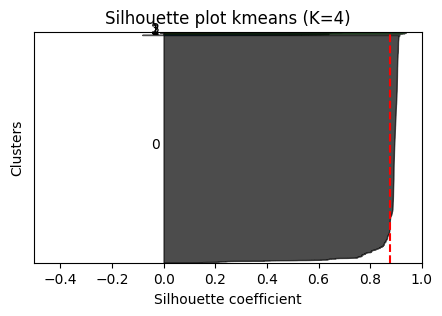

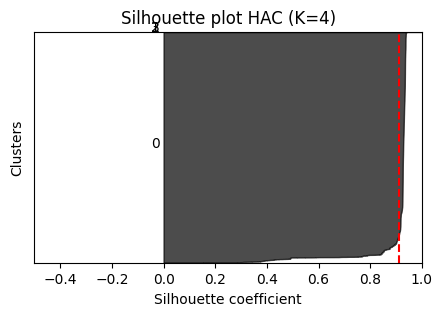

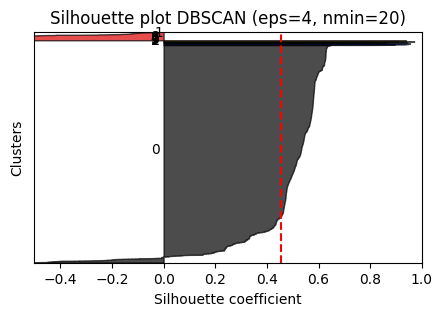

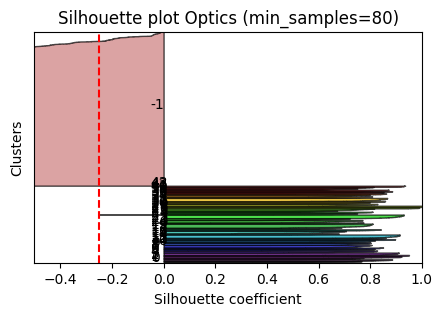

In [20]:
kms_u = KMeans(n_clusters=4, random_state=0).fit(data_unique);drawSillouette(data_unique, kms_u.labels_, "kmeans (K=4)")
hac_u = AgglomerativeClustering(linkage="average", n_clusters=4).fit(data_unique);drawSillouette(data_unique, hac_u.labels_, "HAC (K=4)")
db_u = DBSCAN(eps=4, min_samples=20).fit(data_unique);drawSillouette(data_unique, db_u.labels_, "DBSCAN (eps=4, nmin=20)")
clust_u = OPTICS(min_samples=80).fit(data_unique);drawSillouette(data_unique, clust_u.labels_, "Optics (min_samples=80)")

We then proceeded to assess which approach turned out to be the best for the train and unique datasets, regarding differences in results. <br>
For both datasets we declared that the best algorithm would be Kmeans with 4 clusters.
For the train dataset the silhouette score is lower than the one for unique dataset, however the distribution of the elements among clusters is more homogeneous. 
Overall, we concluded that distance-based methods work better than the others we tried (DBSCAN and OPTICS).

For the second objective we used the clusters produced in objective one to assess the models’ quality with regard to both the train and the unique datasets. As prescribed by the assignment task, we applied extrinsic methods for assessment.

First we created the classes for our dependent variable for both datasets.

In [24]:
y_train = data_train_y.copy()
for i in y_train.index:
    if y_train[i] < 1:
        y_train[i] = "VeryLow" 
    elif 1 <= y_train[i] < 5:
        y_train[i] = "Low" 
    elif 5 <= y_train[i] < 20:
        y_train[i] = "Medium"
    elif 20 <= y_train[i] < 100:
        y_train[i] = "High"
    else:
        y_train[i] = "VeryHigh"

y_train = y_train.values

In [25]:
y_unique = data_unique_y.copy()
for i in y_unique.index:
    if y_unique[i] < 1:
        y_unique[i] = "VeryLow" 
    elif 1 <= y_unique[i] < 5:
        y_unique[i] = "Low" 
    elif 5 <= y_unique[i] < 20:
        y_unique[i] = "Medium"
    elif 20 <= y_unique[i] < 100:
        y_unique[i] = "High"
    else:
        y_unique[i] = "VeryHigh"

y_unique = y_unique.values

We then computed homogenity, completeness and v-measure scores for train and unique datasets.

In [26]:
print("Kmeans Homogeneity score", homogeneity_score(y_train, kms_t.labels_))
print("   HAC Homogeneity score", homogeneity_score(y_train, hac_t.labels_))
print("DBSCAN Homogeneity score", homogeneity_score(y_train, db_t.labels_))
print("OPTICS Homogeneity score", homogeneity_score(y_train, clust_T.labels_))

Kmeans Homogeneity score 0.22333995332072978
   HAC Homogeneity score 0.018757657377691417
DBSCAN Homogeneity score 0.011699479507167723
OPTICS Homogeneity score 0.12271827716319046


In [27]:
print("Kmeans Completeness score", completeness_score(y_train, kms_t.labels_))
print("   HAC Completeness score", completeness_score(y_train, hac_t.labels_))
print("DBSCAN Completeness score", completeness_score(y_train, db_t.labels_))
print("OPTICS Completeness score", completeness_score(y_train, clust_T.labels_))

Kmeans Completeness score 0.29332390331583374
   HAC Completeness score 0.22830435919084696
DBSCAN Completeness score 0.2229919105843231
OPTICS Completeness score 0.11398341070306726


In [28]:
print("Kmeans V-measure score", v_measure_score(y_train, kms_t.labels_))
print("   HAC V-measure score", v_measure_score(y_train, hac_t.labels_))
print("DBSCAN V-measure score", v_measure_score(y_train, db_t.labels_))
print("OPTICS V-measure score", v_measure_score(y_train, clust_T.labels_))

Kmeans V-measure score 0.2535921413233087
   HAC V-measure score 0.03466704438840594
DBSCAN V-measure score 0.02223250957036328
OPTICS V-measure score 0.11818967505266169


According to these scores, for the train dataset, K-means is the approach that performs the best both with intrinsic and extinsic methods, since it has the highest score in homogeneity, completeness and v-measure. 

We then performed the same analysis for unique dataset.

In [52]:
print("Kmeans Homogeneity score", homogeneity_score(y_unique, kms_u.labels_))
print("   HAC Homogeneity score", homogeneity_score(y_unique, hac_u.labels_))
print("DBSCAN Homogeneity score", homogeneity_score(y_unique, db_u.labels_))
print("OPTICS Homogeneity score", homogeneity_score(y_unique, clust_u.labels_))

Kmeans Homogeneity score 0.007347407540523093
   HAC Homogeneity score 0.00021032146087424393
DBSCAN Homogeneity score 0.02314718353319746
OPTICS Homogeneity score 0.1861588878504892


In [53]:
print("Kmeans Completeness score", completeness_score(y_unique, kms_u.labels_))
print("   HAC Completeness score", completeness_score(y_unique, hac_u.labels_))
print("DBSCAN Completeness score", completeness_score(y_unique, db_u.labels_))
print("OPTICS Completeness score", completeness_score(y_unique, clust_u.labels_))

Kmeans Completeness score 0.1765592557836769
   HAC Completeness score 0.1357689820020079
DBSCAN Completeness score 0.10298879508280018
OPTICS Completeness score 0.1295361158455075


In [54]:
print("Kmeans V-measure score", v_measure_score(y_unique, kms_u.labels_))
print("   HAC V-measure score", v_measure_score(y_unique, hac_u.labels_))
print("DBSCAN V-measure score", v_measure_score(y_unique, db_u.labels_))
print("OPTICS V-measure score", v_measure_score(y_unique, clust_u.labels_))

Kmeans V-measure score 0.014107730343704513
   HAC V-measure score 0.0004199923063124947
DBSCAN V-measure score 0.03779889874088777
OPTICS V-measure score 0.15276959711084334


For the unique dataset whereas we had a very good value for the silhlouette score (0.9) when using K-means or HAC, we cannot say the same for extrinsic methods. The algorithm that seems to be the best according to v-measure score is OPTICS. Thus, any of the methods did not provide satisfactionary results.  <br>

To conclude, we can say that the methods used to cluster this dataset did not perform well. The approach that seems to work the best is K-means with 4 clusters: both the silhlouette score and the extrinsic scores are not high, but the distribution of the elements in the clusters is better than the distribution in other approaches. For everything else the majority of the data falls in one cluster.
Here are some reasons why the clustering methods we used did not perfom well:
- given the high dimensionality of the data we worked with, classical clustering approaches not performing so well didn't come as a surprise; we believe approaches as subspace clustering might prove more useful, instead.
- other approaches that come useful ussualy are scaling (standarization, normalization...) and dimensionality reduction methods. We tried both approaches but we got worse results. <br>

For further analysis we recommend trying subspace clustering such as biclustering.
